In [1]:
import numpy as np
import matplotlib.pyplot as plt
import io
import random
from scipy import ndimage
from datasets import load_dataset

c:\Users\Tsewang D Sherpa\Desktop\AI_Project\Milestone3\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
dataset = load_dataset("back2classroom/sidewalks", split="train", streaming=True)
dataset

IterableDataset({
    features: ['filename', 'tfw', 'tif', 'label_tif', 'label_tfw'],
    n_shards: 6
})

In [45]:
type(dataset)

datasets.iterable_dataset.IterableDataset

In [46]:
import numpy as np
from PIL import Image
import io

def bytes_to_image(image_bytes):
    # Convert bytes back to a PIL image
    image_stream = io.BytesIO(image_bytes)
    image = Image.open(image_stream)
    return image

def create_image_samples(dataset, num_samples):
    samples = {'image': [], 'label': []}
    
    for i, entry in enumerate(dataset):
        if i >= num_samples:
            break
        
        # Extract image and label bytes
        image_bytes = entry['tif']
        label_bytes = entry['label_tif']

        # Convert bytes to PIL images
        image = bytes_to_image(image_bytes)
        label = bytes_to_image(label_bytes)

        # Convert images to numpy arrays
        image_array = np.array(image)
        label_array = np.array(label)
        mask_array = np.where(label_array != 0, 1, 0).astype(np.uint8)

        # Add samples to dictionary
        samples['image'].append(image_array)
        samples['label'].append(mask_array)
    
    # Convert lists to numpy arrays
    samples['image'] = np.array(samples['image'])
    samples['label'] = np.array(samples['label'])
    
    return samples

# Usage example
num_samples = 500
sample_images = create_image_samples(dataset, num_samples)



In [47]:
import matplotlib.pyplot as plt

def visualize_samples(samples):
    num_samples = len(samples['image'])

    fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(5, 5*num_samples))

    for i in range(num_samples):
        image = samples['image'][i]
        label = samples['label'][i]

        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(label, cmap='gray')
        axes[i, 1].set_title('Mask (Black and White)')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Usage example
# visualize_samples(sample_images)


In [48]:
sample_images["image"].shape
masks = sample_images["label"]
images = sample_images["image"]

In [49]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (167, 256, 256, 3)
Mask shape: (167, 256, 256)


In [50]:

from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

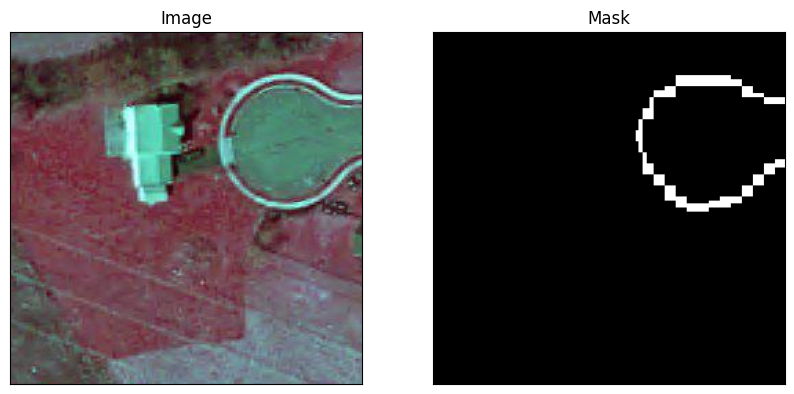

In [51]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [52]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [53]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs
     

In [54]:

# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [55]:

# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [56]:

example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [57]:

# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [58]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [59]:

batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [60]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):

    param.requires_grad_(False)

In [61]:
from torch.optim import Adam
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)


In [64]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
from statistics import mean

# Define the Cross-Entropy Loss function
def ce_loss(predicted, target):
    return torch.nn.functional.cross_entropy(predicted, target)

# Define the Dice Loss function
def dice_loss(predicted, target):
    smooth = 1e-6
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

# Training loop
def train_model(model, train_dataloader, optimizer, num_epochs=1, device="cuda"):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        epoch_losses = []
        for batch in tqdm(train_dataloader):
            # Move data to device
            pixel_values = batch["pixel_values"].to(device)
            input_boxes = batch["input_boxes"].to(device)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)

            # Forward pass
            outputs = model(pixel_values=pixel_values, input_boxes=input_boxes, multimask_output=False)

            # Compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            loss = dice_loss(predicted_masks, ground_truth_masks.unsqueeze(1))  # Using CE Loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Optimization step
            optimizer.step()

            epoch_losses.append(loss.item())

        # Print epoch loss
        print(f'EPOCH: {epoch}')
        print(f'Mean loss: {mean(epoch_losses)}')

# Example usage:



In [65]:
train_model(model, train_dataloader, optimizer, num_epochs=50, device="cuda")

100%|██████████| 84/84 [00:35<00:00,  2.39it/s]


EPOCH: 0
Mean loss: 0.9956039949542


100%|██████████| 84/84 [00:34<00:00,  2.40it/s]


EPOCH: 1
Mean loss: 1.0108115339563006


100%|██████████| 84/84 [00:35<00:00,  2.39it/s]


EPOCH: 2
Mean loss: 1.031611972621509


100%|██████████| 84/84 [00:35<00:00,  2.38it/s]


EPOCH: 3
Mean loss: 1.010410406759807


100%|██████████| 84/84 [00:41<00:00,  2.02it/s]


EPOCH: 4
Mean loss: 1.0023111708107448


100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


EPOCH: 5
Mean loss: 1.002164968422481


100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


EPOCH: 6
Mean loss: 0.9986578736986432


100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


EPOCH: 7
Mean loss: 0.9845876338936034


100%|██████████| 84/84 [00:34<00:00,  2.45it/s]


EPOCH: 8
Mean loss: 0.9779312759637833


100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


EPOCH: 9
Mean loss: 0.9837361559981391


100%|██████████| 84/84 [00:34<00:00,  2.45it/s]


EPOCH: 10
Mean loss: 0.9730689944255919


100%|██████████| 84/84 [00:34<00:00,  2.45it/s]


EPOCH: 11
Mean loss: 0.974280229636601


100%|██████████| 84/84 [00:33<00:00,  2.47it/s]


EPOCH: 12
Mean loss: 0.9493351599999836


100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


EPOCH: 13
Mean loss: 0.9239438225825628


100%|██████████| 84/84 [00:34<00:00,  2.46it/s]


EPOCH: 14
Mean loss: 0.9534548499754497


100%|██████████| 84/84 [00:33<00:00,  2.48it/s]


EPOCH: 15
Mean loss: 0.9529562855050677


100%|██████████| 84/84 [00:33<00:00,  2.48it/s]


EPOCH: 16
Mean loss: 0.9522217639854976


100%|██████████| 84/84 [00:34<00:00,  2.46it/s]


EPOCH: 17
Mean loss: 0.9507146690573011


100%|██████████| 84/84 [00:33<00:00,  2.47it/s]


EPOCH: 18
Mean loss: 0.9508562279599053


100%|██████████| 84/84 [00:34<00:00,  2.42it/s]


EPOCH: 19
Mean loss: 0.9480147908131281


100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


EPOCH: 20
Mean loss: 0.9473840083394732


100%|██████████| 84/84 [00:33<00:00,  2.48it/s]


EPOCH: 21
Mean loss: 0.9463594924835932


100%|██████████| 84/84 [00:33<00:00,  2.48it/s]


EPOCH: 22
Mean loss: 0.9451555169764019


100%|██████████| 84/84 [00:50<00:00,  1.66it/s]


EPOCH: 23
Mean loss: 0.9448799937963486


100%|██████████| 84/84 [00:42<00:00,  1.99it/s]


EPOCH: 24
Mean loss: 0.944081438439233


100%|██████████| 84/84 [00:35<00:00,  2.38it/s]


EPOCH: 25
Mean loss: 0.9431605026835487


100%|██████████| 84/84 [00:34<00:00,  2.42it/s]


EPOCH: 26
Mean loss: 0.9409463597195489


100%|██████████| 84/84 [00:34<00:00,  2.44it/s]


EPOCH: 27
Mean loss: 0.9395017176866531


100%|██████████| 84/84 [00:34<00:00,  2.44it/s]


EPOCH: 28
Mean loss: 0.9394604563713074


100%|██████████| 84/84 [00:34<00:00,  2.45it/s]


EPOCH: 29
Mean loss: 0.9367063889900843


100%|██████████| 84/84 [00:34<00:00,  2.44it/s]


EPOCH: 30
Mean loss: 0.9378419043052764


100%|██████████| 84/84 [00:34<00:00,  2.45it/s]


EPOCH: 31
Mean loss: 0.9373203331515902


100%|██████████| 84/84 [00:34<00:00,  2.45it/s]


EPOCH: 32
Mean loss: 0.9357740261725017


100%|██████████| 84/84 [00:34<00:00,  2.46it/s]


EPOCH: 33
Mean loss: 0.9326438073601041


100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


EPOCH: 34
Mean loss: 0.9281687850043887


100%|██████████| 84/84 [00:34<00:00,  2.46it/s]


EPOCH: 35
Mean loss: 0.9309243751423699


100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


EPOCH: 36
Mean loss: 0.9284765181087312


100%|██████████| 84/84 [00:34<00:00,  2.46it/s]


EPOCH: 37
Mean loss: 0.9275854570525033


100%|██████████| 84/84 [00:34<00:00,  2.46it/s]


EPOCH: 38
Mean loss: 0.9257575805698123


100%|██████████| 84/84 [00:34<00:00,  2.46it/s]


EPOCH: 39
Mean loss: 0.919520630013375


100%|██████████| 84/84 [00:34<00:00,  2.46it/s]


EPOCH: 40
Mean loss: 0.9225010630630311


100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


EPOCH: 41
Mean loss: 0.9289990798348472


100%|██████████| 84/84 [00:34<00:00,  2.47it/s]


EPOCH: 42
Mean loss: 5.131288006901741


100%|██████████| 84/84 [00:34<00:00,  2.46it/s]


EPOCH: 43
Mean loss: 0.9476974124000186


100%|██████████| 84/84 [00:36<00:00,  2.32it/s]


EPOCH: 44
Mean loss: 0.9464528234232039


100%|██████████| 84/84 [00:38<00:00,  2.15it/s]


EPOCH: 45
Mean loss: 0.9439659707603001


100%|██████████| 84/84 [00:38<00:00,  2.20it/s]


EPOCH: 46
Mean loss: 0.9425078417573657


100%|██████████| 84/84 [00:38<00:00,  2.17it/s]


EPOCH: 47
Mean loss: 0.9361522552512941


100%|██████████| 84/84 [00:49<00:00,  1.68it/s]


EPOCH: 48
Mean loss: 0.9378421959422883


100%|██████████| 84/84 [00:57<00:00,  1.47it/s]

EPOCH: 49
Mean loss: 0.9384241927237738


In [83]:
torch.save(model.state_dict(), "./sideWalk_cp_12thAttemp.pth")

In [84]:

from transformers import SamModel, SamConfig, SamProcessor
import torch

In [91]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
sidewalkModel = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
sidewalkModel.load_state_dict(torch.load("./sideWalk_cp_12thAttemp.pth"))
     

<All keys matched successfully>

In [92]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
sidewalkModel.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

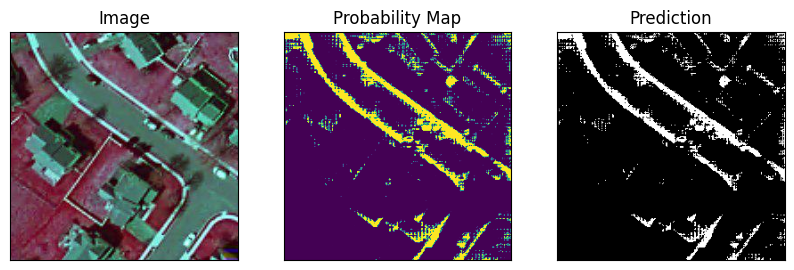

In [196]:
array_size = 2000

# Define the size of your grid
grid_size = 5

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)


inpimg = dataset[72]["image"]
inputs = processor(inpimg, input_points=input_points, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

sidewalkModel.eval()

with torch.no_grad():
  outputs = sidewalkModel(**inputs, multimask_output=False)


single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.99).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(inpimg), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

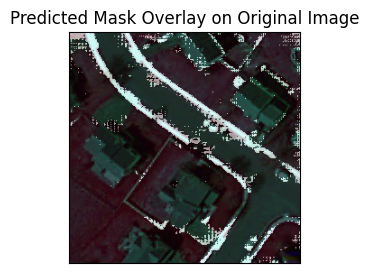

In [216]:
array_size = 2000
grid_size = 5

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

# Reshape grid to expected shape of input_points tensor
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

# Get input image
inpimg = dataset[72]["image"]
inputs = processor(inpimg, input_points=input_points, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

sidewalkModel.eval()

with torch.no_grad():
    outputs = sidewalkModel(**inputs, multimask_output=False)

# Convert soft mask to hard mask
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.99).astype(np.uint8)

# Plot the image and prediction
fig, ax = plt.subplots(figsize=(3, 3))

# Plot the original image
ax.imshow(np.array(inpimg), cmap='gray')

# Overlay the prediction as a mask with transparency
ax.imshow(single_patch_prediction, cmap='gray', alpha=0.6)

# Set titles and hide axis ticks and labels
ax.set_title("Predicted Mask Overlay on Original Image")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()
